# epitopepredict advanced analyses

### References:
* Paul, S. et al., 2015. Development and validation of a broad scheme for prediction of HLA class II restricted T cell epitopes. Journal of Immunological Methods, 422, pp.28–34. Available at: http://dx.doi.org/10.1016/j.jim.2015.03.022.
* Terry, F.E. et al., 2014. Time for T? Immunoinformatics addresses vaccine design for neglected tropical and emerging infectious diseases. Expert review of vaccines, 9, pp.1–15. Available at: http://www.ncbi.nlm.nih.gov/pubmed/25193104.


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.width', 100)
pd.set_option('max_colwidth', 80)
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
sns.set_context("notebook", font_scale=1.4)
from IPython.display import display, HTML

import epitopepredict as ep
from epitopepredict import base, sequtils, analysis

In [2]:
genbankfile = '../testing/zaire-ebolavirus.gb'
zaire = sequtils.genbank2Dataframe(genbankfile, cds=True)
savepath = 'test_iedbmhc1'
Pi = ep.getPredictor('iedbmhc1')
alleles = ep.mhc1_supertypes
Pi.predictProteins(zaire,length=11,alleles=alleles,path=savepath,overwrite=False)
Pi.load(path=savepath)

predictions done for 9 proteins in 6 alleles
results saved to /home/farrell/gitprojects/epitopepredict/examples/test_iedbmhc1


## Binder clustering for finding regions with possible epitopes

One application of immunoinformatics is to screen out likely candidate antigens from the genome for further study. To do this using epitope prediction requires filtering the many potential binders in each protein. There is no theoretical basis for doing this.

**Epitope clustering** has been previously observed to be an indicator of T cell epitope regions. The `findClusters` method in the analysis module allows automatic cluster detection from a set of predicted binders from one or more proteins. It can be done for a whole genome.

The result is a table of sequence regions with the number of binders and density of epitope cluster.

In [32]:
#find clusters of binders in these results
pb = Pi.promiscuousBinders(cutoff=5,n=2)
cl = analysis.findClusters(pb, dist=10, min_size=3, genome=zaire)
display(cl[:20])

40 clusters found in 7 proteins


,name,start,end,binders,clustersize,gene,peptide
0,ZEBOVgp7,1451,1481,7,30,L,FTTHFLTYPKIGLLYSFGAFVSYYLGNTIL
1,ZEBOVgp1,176,215,6,39,NP,QVHAEQGLIQYPTAWQSVGHMMVIFRLMRTNFLIKFLLI
2,ZEBOVgp7,95,118,5,23,L,CQQFLDEIIKYTMQDALFLKYYL
3,ZEBOVgp7,1962,1987,5,25,L,VFLSDTEGMLWLNDNLAPFFATGYL
4,ZEBOVgp5,224,249,4,25,VP30,ALWQQWDRQSLIMFITAFLNIALQL
5,ZEBOVgp4.2,15,35,4,20,GP,RTSFFLWVIILFQRTFSIPL
6,ZEBOVgp7,139,158,3,19,L,IQGNEFLHQMFFWYDLAIL
7,ZEBOVgp1,142,160,3,18,NP,TEANAGQFLSFASLFLPK
8,ZEBOVgp4.2,225,252,3,27,GP,GTNETEYLFEVDNLTYVQLESRFTPQF
9,ZEBOVgp3,165,186,3,21,VP40,VQLPQYFTFDLTALKLITQPL


## plot regions on sequence 
We can use this to see where our clusters are in the sequence, for exmaple

In [ ]:
ep.plotting.plot_multiple([Pi], name, regions=cl, n=2)

## overlaps

In [ ]:
name = 'ZEBOVgp6'
Pn = ep.getPredictor('netmhciipan')
savepath2='test_netmhciipan'
alleles2 = ep.mhc2_supertypes
Pn.predictProteins(zaire,length=11,alleles=alleles2,path=savepath2,overwrite=False)
Pn.load(path=savepath2)

cl = analysis.getOverlaps(cl,Pn.promiscuousBinders(n=2,cutoff=5),label='mhc2_ovlp')

#plot both sets of binders and overlay region of cluster in previous data
ax = ep.plot_tracks([Pi,Pn],name=name,legend=True,figsize=(14,4),n=2)
r = cl[cl.name==name]
print r
coords = (list(r.start),list(r.end-r.start))
coords = zip(*coords)
ep.plot_regions(coords, ax, color='gray')

## conservation analysis
Conservation of epitopes may be important across strains or species.

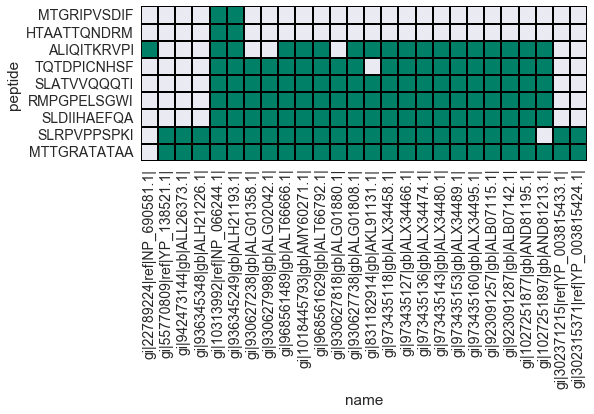

In [39]:
reload(ep.base)
reload(analysis)
reload(sequtils)

name = 'ZEBOVgp2'
proteinseq = zaire[zaire.locus_tag==name].translation.iloc[0]
#print proteinseq
#print pb
seqs = pb.peptide

#provide a list of seqs (e.g. strains)
filename='ebola_VP35.fa'
r = sequtils.fetch_protein_sequences('Filovirus[Orgn] AND VP35[Gene]', filename=filename)
#align fasta sequences
aln = sequtils.muscle_alignment(filename)
#sequtils.showAlignment(aln)
alnrows = sequtils.alignment2Dataframe(aln)

#print (sequtils.formatAlignment(aln))
#print alnrows[:25][['accession','definition','perc_ident']]
c = analysis.epitope_conservation(seqs, alnrows=alnrows)

## use a local blast database to find orthologs and conservation of your epitopes

In [23]:
#blast seq locally to get an alignment with orthologs
localdb = '../db/viral_refseq'
blr = analysis.get_orthologs(proteinseq, db=localdb)
alnrows, aln = analysis.alignBlastResults(blr)
alnrows.to_csv('%s_aligned.csv' %name)
print alnrows

running blast..
7 hits, 7 filtered
          expect  identity       accession                                   definition  \
0  1.594970e-164       229  YP_003815438.1       minor nucleoprotein [Bundibugyo virus]   
1  1.039930e-160       224  YP_003815429.1  minor nucleoprotein [Tai Forest ebolavirus]   
2  2.252660e-143       198     NP_690585.1      minor nucleoprotein [Reston ebolavirus]   
3  1.533020e-138       193     YP_138525.1       minor nucleoprotein [Sudan ebolavirus]   
4   3.305730e-84       146  YP_004928140.1      minor nucleoprotein [Lloviu cuevavirus]   
5   1.945650e-41        88  YP_001531157.1   minor nucleoprotein [Marburg marburgvirus]   
6   2.087880e-40        87  YP_009055226.1   minor nucleoprotein [Marburg marburgvirus]   

   perc_ident                                                                              seq  
0   79.513889  -------MDSFHERGRSRTIRQSARDGPSHQVRTRSSSRDSHRSEYHTPRSSSQVRVPTVFHRKRTDSLTVPPAPK...  
1   77.777778  -------MEVVHERGRSRISRQNTRDG